# Bayesian Hierarchical Modeling

In [36]:
import numpy 
import pymc
import pytensor.tensor as at


In [37]:
import sys
import os


# Get the absolute path to the directory containing 'src'
project_dir = os.path.abspath("..")
sys.path.append(project_dir)

In [38]:
from src.simulation.simulation_space import DestinationPoint, StartingPoint, SimulationSpace
from src.simulation.agent import Agent
from src.simulation.simulation import Simulation

Simulation complete! All agents have reached their destinations.


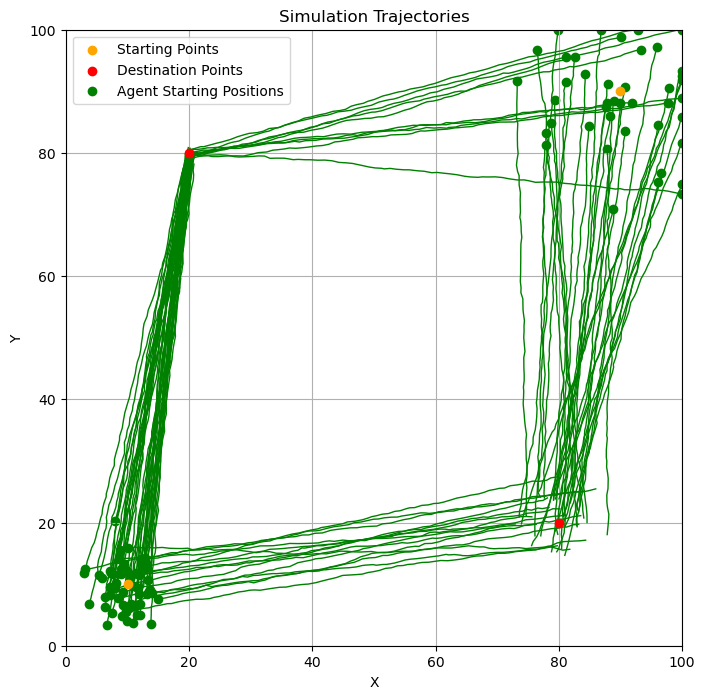

In [39]:
# Define destination points with the new stopping point logic
destination_1 = DestinationPoint(x=20, y=80, stop_mean=2.0, stop_std=0.5)
destination_2 = DestinationPoint(x=80, y=20, stop_mean=5.0, stop_std=3.0)

# Initialize the simulation space
space = SimulationSpace(size=(100, 100), destination_points=[destination_1, destination_2])

# Add starting points
starting_point_1 = StartingPoint(x=10, y=10, simulation_space=space, position_std=3.0, destination_probs=[0.8, 0.2])
starting_point_2 = StartingPoint(x=90, y=90, simulation_space=space, position_std=8.0, destination_probs=[0.2, 0.8])
space.add_starting_point(starting_point_1)
space.add_starting_point(starting_point_2)

# Create agents
agents = []
for _ in range(100):  # Generate agents
    agent = Agent(simulation_space=space)
    agent.initialize_agent()
    agents.append(agent)

# Add agents to the simulation space
for agent in agents:
    space.add_agent(agent)

# Run the simulation
train_simulation = Simulation(simulation_space=space, agents=agents)
train_simulation.run_simulation()

# Visualize the trajectories
train_simulation.visualize_trajectories()

Simulation complete! All agents have reached their destinations.


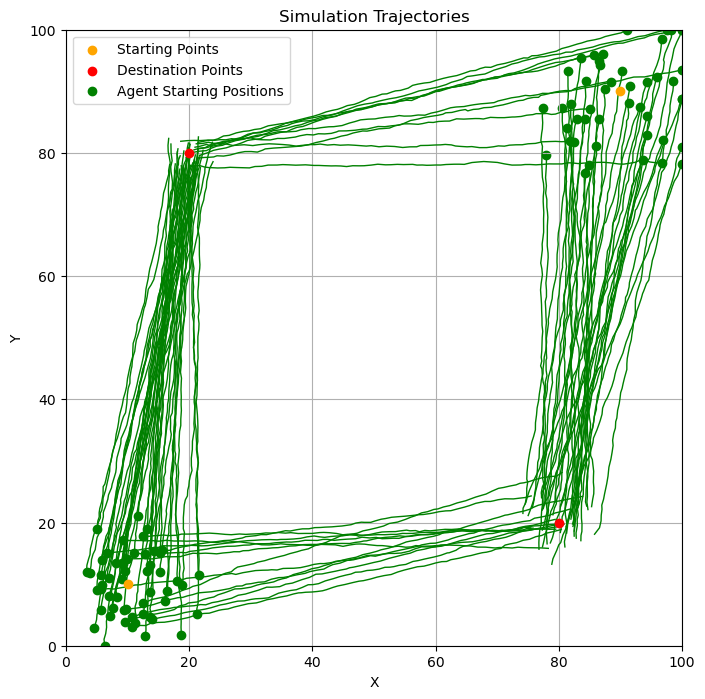

In [40]:
# Define destination points with the new stopping point logic
destination_1 = DestinationPoint(x=20, y=80, stop_mean=4.0, stop_std=1.5)
destination_2 = DestinationPoint(x=80, y=20, stop_mean=7.0, stop_std=3.0)

# Initialize the simulation space
space = SimulationSpace(size=(100, 100), destination_points=[destination_1, destination_2])

# Add starting points
starting_point_1 = StartingPoint(x=10, y=10, simulation_space=space, position_std=5.0, destination_probs=[0.8, 0.2])
starting_point_2 = StartingPoint(x=90, y=90, simulation_space=space, position_std=8.0, destination_probs=[0.2, 0.8])
space.add_starting_point(starting_point_1)
space.add_starting_point(starting_point_2)

# Create agents
agents = []
for _ in range(100):  # Generate agents
    agent = Agent(simulation_space=space)
    agent.initialize_agent()
    agents.append(agent)

# Add agents to the simulation space
for agent in agents:
    space.add_agent(agent)

# Run the simulation
test_simulation = Simulation(simulation_space=space, agents=agents)
test_simulation.run_simulation()

# Visualize the trajectories
test_simulation.visualize_trajectories()

test_trajectories = test_simulation.trajectories

In [41]:
train_data = train_simulation.trajectories
test_data = test_simulation.trajectories

## Preparing Data

In [42]:
import matplotlib.pyplot as plt
import numpy as np

def plot_trajectories(trajectories, title="Trajectories"):
    """
    Plots a set of trajectories.
    
    Parameters:
    -----------
    trajectories : dict or list
        If a dict, keys are agent IDs and values are lists of (x, y) tuples.
        If a list, it's a list of trajectories (each a list of (x, y) tuples).
    title : str, optional
        Title of the plot.
    """
    plt.figure(figsize=(10, 8))
    
    # Check if trajectories is a dictionary or list
    if isinstance(trajectories, dict):
        for agent_id, traj in trajectories.items():
            traj = np.array(traj)  # Convert to numpy array for easier slicing
            plt.plot(traj[:, 0], traj[:, 1], linestyle='-', 
                     label=f"Agent {agent_id}", alpha=0.7)
            # Mark starting and ending points
            plt.scatter(traj[0, 0], traj[0, 1], color='green', s=100, marker='s')
            plt.scatter(traj[-1, 0], traj[-1, 1], color='red', s=100, marker='X')
    elif isinstance(trajectories, list):
        for i, traj in enumerate(trajectories):
            traj = np.array(traj)
            plt.plot(traj[:, 0], traj[:, 1], linestyle='-', 
                     label=f"Trajectory {i}", alpha=0.7)
            plt.scatter(traj[0, 0], traj[0, 1], color='green', s=100, marker='s')
            plt.scatter(traj[-1, 0], traj[-1, 1], color='red', s=100, marker='X')
    
    plt.xlabel("X coordinate")
    plt.ylabel("Y coordinate")
    plt.title(title)
    plt.grid(True)
    plt.show()

# Example usage:
# plot_trajectories(imputed_train_data, title="Imputed Trajectories")

In [43]:
def interpolate_trajectory(traj, target_length):
    """
    Interpolate a 2D trajectory (list of (x,y) tuples) to have target_length points.
    Assumes the trajectory points are sampled at uniform time intervals.
    """
    traj = np.array(traj)  # shape: (original_length, 2)
    orig_length = traj.shape[0]
    
    # Define original and target time points on [0, 1]
    orig_times = np.linspace(0, 1, orig_length)
    target_times = np.linspace(0, 1, target_length)
    
    # Perform linear interpolation for each coordinate
    x_interp = np.interp(target_times, orig_times, traj[:, 0])
    y_interp = np.interp(target_times, orig_times, traj[:, 1])
    
    # Combine the interpolated coordinates
    return list(zip(x_interp, y_interp))

# Determine the maximum trajectory length in train_data
max_length = max(len(traj) for traj in train_data.values())

# Create a new dictionary with imputed trajectories of uniform length
imputed_train_data = {}
for agent_id, traj in train_data.items():
    if len(traj) < max_length:
        imputed_train_data[agent_id] = interpolate_trajectory(traj, max_length)
    else:
        imputed_train_data[agent_id] = traj



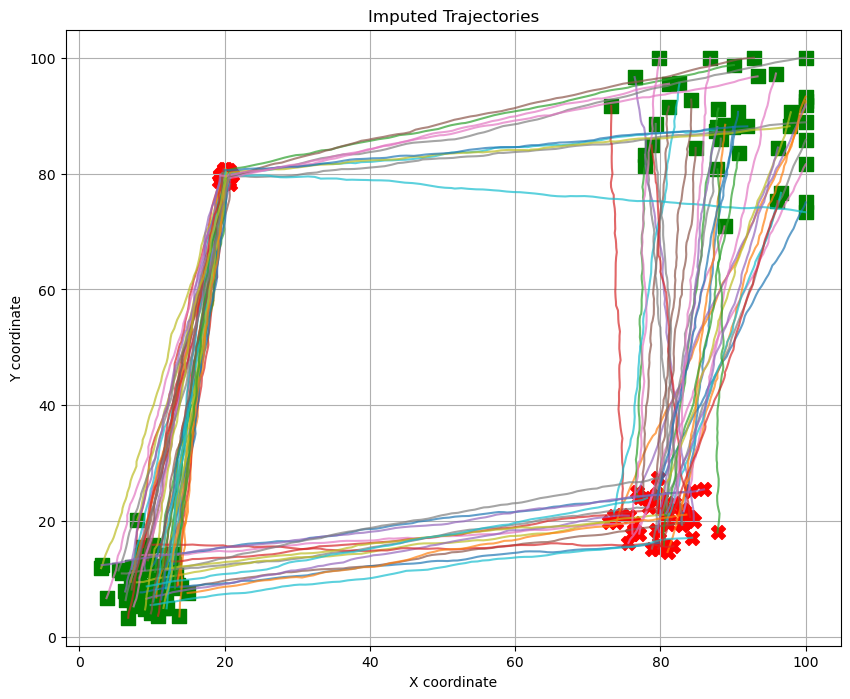

In [44]:
plot_trajectories(imputed_train_data, title="Imputed Trajectories")

In [45]:
agent_ids = list(imputed_train_data.keys())
num_agents = len(agent_ids)
T = len(imputed_train_data[agent_ids[0]])  # number of time steps per trajectory

# Convert trajectories dictionary into a NumPy array of shape (num_agents, T, 2)
data = np.array([imputed_train_data[agent_id] for agent_id in agent_ids])
# Extract positions: shape (num_agents, T)
x_obs = data[:, :, 0]
y_obs = data[:, :, 1]

# Compute approximate velocities as differences between consecutive positions
# Shape will be (num_agents, T-1, 2)
velocities = data[:, 1:, :] - data[:, :-1, :]
dt = 1.0  # assume constant time step

# Assume two possible goals; here we define their coordinates (could be parameters too)
goal_coords = np.array([[20.0, 80.0],
                        [80.0, 20.0]])

## Define the Model

In [69]:
with pm.Model() as model:
    # Hyperpriors for the agent-specific influence parameter alpha
    mu_alpha = pm.Normal("mu_alpha", mu=1.0, sigma=1.0)
    tau_alpha = pm.HalfCauchy("tau_alpha", beta=1.0)
    
    # Observation noise
    sigma = pm.HalfCauchy("sigma", beta=1.0)
    
    # Agent-specific influence parameters
    alpha = pm.Normal("alpha", mu=mu_alpha, sigma=tau_alpha, shape=num_agents)
    
    # Prior on the latent goal probabilities (for 2 goals)
    pi = pm.Dirichlet("pi", a=np.ones(2))
    
    # Latent goal assignment for each agent (0 or 1)
    G = pm.Categorical("G", p=pi, shape=num_agents)
    
    # Convert the entire array to a tensor variable
    goal_coords_tt = at.as_tensor_variable(goal_coords)
    
    # Use G to index the goal coordinates for each agent
    goal_x = goal_coords_tt[G, 0]
    goal_y = goal_coords_tt[G, 1]
    
    # Expand agent-specific alpha, goal_x, and goal_y to match the time dimension.
    alpha_expanded = alpha[:, None]  # shape (num_agents, 1)
    goal_x_expanded = goal_x[:, None]  # shape (num_agents, 1)
    goal_y_expanded = goal_y[:, None]  # shape (num_agents, 1)
    
    # Expected values (for time steps 0 to T-2)
    x_mu = x_obs[:, :-1] + dt * (velocities[:, :, 0] + alpha_expanded * (goal_x_expanded - x_obs[:, :-1]))
    y_mu = y_obs[:, :-1] + dt * (velocities[:, :, 1] + alpha_expanded * (goal_y_expanded - y_obs[:, :-1]))
    
    # Define the observed data using pm.Data so that it can be updated later.
    x_like_data = pm.Data("x_like", x_obs[:, 1:])
    y_like_data = pm.Data("y_like", y_obs[:, 1:])
    
    # Likelihood: use the shared data in the likelihood definition.
    x_obs_likelihood = pm.Normal("x_obs_likelihood", mu=x_mu, sigma=sigma, observed=x_like_data)
    y_obs_likelihood = pm.Normal("y_obs_likelihood", mu=y_mu, sigma=sigma, observed=y_like_data)

In [70]:
with model:
    # Run MCMC: draw 2000 samples with a tuning period of 1000 iterations.
    trace = pm.sample(draws=2000, tune=1000, target_accept=0.9, cores=6, random_seed=42)

Multiprocess sampling (6 chains in 6 jobs)
CompoundStep
>NUTS: [mu_alpha, tau_alpha, sigma, alpha, pi]
>BinaryGibbsMetropolis: [G]


/Users/nigeldoering/miniconda3/envs/community_detection/lib/python3.11/site-packages/rich/live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 6 chains for 1_000 tune and 2_000 draw iterations (6_000 + 12_000 draws total) took 56 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


## Posterior Predictive Check #1 Generate New Trajectories

In [71]:
import pymc as pm
import matplotlib.pyplot as plt
import numpy as np

# Generate posterior predictive samples. Here, we force a dictionary output.
with model:
    ppc = pm.sample_posterior_predictive(trace, var_names=["x_like", "y_like"], 
                                           random_seed=42, return_inferencedata=False)

# ppc["x_like"] and ppc["y_like"] should have shape (n_samples, n_agents, T_obs)
# where T_obs is the number of time steps in the observed data (likely T-1 if you predicted from t=0 to t=T-1).
print("ppc['x_like'] shape:", ppc["x_like"].shape)  # for example: (2000, 100, T_obs)
print("ppc['y_like'] shape:", ppc["y_like"].shape)

# Define how many samples and agents you want to plot
n_samples_to_plot = 10  # number of posterior predictive samples
n_agents_to_plot = 5    # number of agents to plot


Sampling: []


/Users/nigeldoering/miniconda3/envs/community_detection/lib/python3.11/site-packages/rich/live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ppc['x_like'] shape: (6, 2000, 100, 85)
ppc['y_like'] shape: (6, 2000, 100, 85)


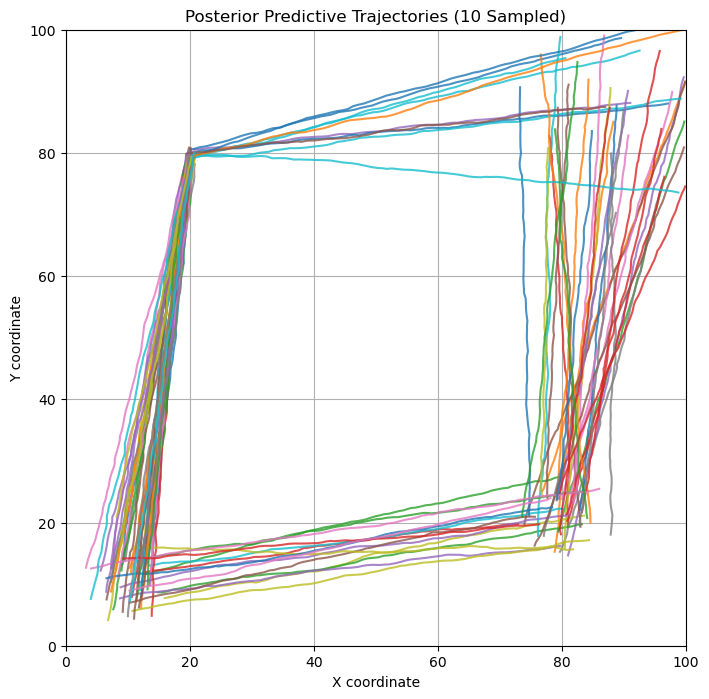

In [72]:
import matplotlib.pyplot as plt
import numpy as np

# Select one chain and one sample; here we take chain 0 and sample 0 for simplicity.
chain_idx = 0
sample_idx = 0

# Get the number of agents from the third dimension of the posterior predictive samples.
n_agents = ppc["x_like"].shape[2]

# Randomly select 10 unique agent indices.
selected_agents = np.random.choice(n_agents, size=100, replace=False)

plt.figure(figsize=(8, 8))

for agent in selected_agents:
    # Extract the trajectory for the given chain, sample, and agent.
    traj_x = ppc["x_like"][chain_idx, sample_idx, agent, :]
    traj_y = ppc["y_like"][chain_idx, sample_idx, agent, :]
    
    # Plot the trajectory
    plt.plot(traj_x, traj_y, markersize=3, label=f"Agent {agent}", alpha=0.8)

# Set the grid to be 100x100.
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.title("Posterior Predictive Trajectories (10 Sampled)")
plt.grid(True)
plt.show()

## Posterior Predictive Check #2 Infer Goals

In [78]:
test_agent_id = list(test_data.keys())[0]  # select the first test agent
test_traj = test_data[test_agent_id]
print("Selected test agent:", test_agent_id)
print("Original test trajectory length:", len(test_traj))

# Convert to a NumPy array: shape (T_full, 2)
test_traj = np.array(test_traj)
T_full = test_traj.shape[0]

# Use only the first fraction of the trajectory (e.g., 30%)
fraction = 0.3
T_partial = int(np.floor(fraction * T_full))
if T_partial < 2:
    raise ValueError("Not enough time steps for a partial trajectory!")

# Extract the partial trajectory: shape (T_partial, 2)
partial_traj = test_traj[:T_partial, :]
test_x_obs = partial_traj[:, 0]  # shape (T_partial,)
test_y_obs = partial_traj[:, 1]  # shape (T_partial,)

# Compute approximate velocities using differences.
# These are used for the model dynamics (for time steps 0 to T_partial-2).
test_vel_x = np.diff(test_x_obs)  # shape (T_partial - 1,)
test_vel_y = np.diff(test_y_obs)  # shape (T_partial - 1,)

# Define a time step (dt) value.
dt = 1.0

Selected test agent: 0
Original test trajectory length: 72


In [80]:
# Assume these values come from your training model's posterior (e.g., using np.mean(trace["..."]))
mu_alpha_val = trace.posterior["mu_alpha"].mean().values
tau_alpha_val = trace.posterior["tau_alpha"].mean().values
sigma_val = trace.posterior["sigma"].mean().values
pi_val = trace.posterior["pi"].mean(dim=["chain", "draw"]).values

# Pre-compute the sliced observed data outside the model.
# We want the observations at time steps 1 to T_partial.
x_obs_slice = test_x_obs[1:]
y_obs_slice = test_y_obs[1:]

with pm.Model() as single_agent_model:
    # Use fixed hyperparameters from training:
    mu_alpha_fixed = mu_alpha_val  # e.g., a scalar from training
    tau_alpha_fixed = tau_alpha_val
    sigma_fixed = sigma_val
    pi_fixed = pi_val  # array of length 2 for 2 goals

    # Agent-specific parameter for this test agent:
    alpha = pm.Normal("alpha", mu=mu_alpha_fixed, sigma=tau_alpha_fixed)
    
    # Latent goal assignment:
    G = pm.Categorical("G", p=pi_fixed)
    
    # Convert goal coordinates to tensor variable and index:
    goal_coords_tt = at.as_tensor_variable(goal_coords)  # shape (2, 2)
    goal_x = goal_coords_tt[G, 0]
    goal_y = goal_coords_tt[G, 1]
    
    # Define observed data as shared variables for the full test trajectory.
    # These will be used to compute the expected values.
    test_x_data = pm.Data("test_x_data", test_x_obs)  # shape (T_partial,)
    test_y_data = pm.Data("test_y_data", test_y_obs)  # shape (T_partial,)
    
    # Compute approximate velocities outside (we assume these are pre-computed):
    # test_vel_x and test_vel_y should have shape (T_partial - 1,)
    # (We assume they were computed using np.diff on test_x_obs and test_y_obs.)
    
    # Compute expected values for time steps 0 to T_partial-2.
    # Note: test_x_data[:-1] is a sub-tensor, but that's fine for computing mu.
    x_mu = test_x_data[:-1] + dt * (test_vel_x + alpha * (goal_x - test_x_data[:-1]))
    y_mu = test_y_data[:-1] + dt * (test_vel_y + alpha * (goal_y - test_y_data[:-1]))
    
    # Use the pre-computed NumPy arrays (x_obs_slice and y_obs_slice) as observed data.
    x_obs_likelihood = pm.Normal("x_obs_likelihood", mu=x_mu, sigma=sigma_fixed, observed=x_obs_slice)
    y_obs_likelihood = pm.Normal("y_obs_likelihood", mu=y_mu, sigma=sigma_fixed, observed=y_obs_slice)
    
    # Now run inference on the single-agent model.
    test_trace = pm.sample(draws=1000, tune=500, chains=2, target_accept=0.9, random_seed=42)



Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [alpha]
>BinaryGibbsMetropolis: [G]


/Users/nigeldoering/miniconda3/envs/community_detection/lib/python3.11/site-packages/rich/live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


KeyError: 'G'

In [81]:
inferred_G = test_trace.posterior["G"]
print("Inferred latent goal samples for test agent:")
print(inferred_G)

Inferred latent goal samples for test agent:
<xarray.DataArray 'G' (chain: 2, draw: 1000)> Size: 16kB
array([[0, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 1, 0, 1]])
Coordinates:
  * chain    (chain) int64 16B 0 1
  * draw     (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
